# N-grams, Fastttext, and GloVE

*This assignment focuses on exploring Fasttext and GloVE as NLP methods. We are going to focus on two tasks and ways of understanding models:*

1. *The traditional, "model is a classifier" viewpoint. Here we are going to work with the [AG News Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) to classify genres*
2. *The more vector-based way, seeing them basically as machines that just generate word vectors, with everything else just being gravy. Barring attaching a specific classifier, GloVE falls entirely under this category.* 

*In this assignment, we are mainly going to be using the [AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset), a corpus of more than 1 million news articles, each classified as one of four classes: 'Business', 'Sci/Tech', 'World', or 'Sports'. Note, that because of the semi-supervised nature of most methods used in this assignment, we could almost do the whole thing without the labels. They're just there to make it a bit simpler and to provide an obvious usecase.*

**For the GloVe part, note that you can download all their pretrained vectors at the [GloVe project page](https://nlp.stanford.edu/projects/glove/).**

## 0. Extra primer on Fasttext

*As you know, n-grams are pretty useful for improving the otherwise limited bag-of-words (BoW) model. Most often, this is by making distinctions between sentences such as "good" and "not good" which would be represented somewhat the same in a regular BoW. It is very obvious if we consider the sentence "Maria stole the milk" vs "The milk stole Maria", two sentences completely identical in the BoW representation, but with two obviously different meanings.*

*As you also know, Fasttext takes this further by creating chracter-wise n-grams. These are made up of n-characters of a single word. This allows fasttext to consider cases such as grammar, where words are spelled similarly and even consider misspellings, if someone makes a mistaek in wirtign a wrod, the character-wise n-gram representation will be **almost** the same as the correct word.*

This is done by Fasttext simply storing embedding vectors $v_n$ for each n-gram, character or otherwise. Fasttext will simply then average all of these vectors, word, character-wise n-grams, and word-wise n-grams to create the representation for a given text or sentence.

$$v_{total} = \frac{1}{N}\sum^N_{n=0} v_n$$

### Important note: Fasttext supervised and unsupervised

*If you look into the technical documentation for the fasttext model, you'll notice that there are options to train both an **unsupervised** and a **supervised** version of the fasttext model. These use similar approaches, but it is arguably the unsupervised model that best describes what the fasttext team wanted to accomplish: efficient word-vector generation for downstream usage.*

***The supervised model:***
- *Needs a corpus of text with given labels to train*
- *Does not use skipgram/CBoW, but just works as a 'normal' FFN for classification*
- *Uses character-wise n-grams*
- *Uses word-wise n-grams the same way as the unsupervised model uses character-wise n-grams, treating them as vectors and combining them in the end for the final classification.*
- *Can be directly evaluated by just checking how good it is at predicting the given classes.*

***The unsupervised model:*** (not important for this assignment or course, just cool to know)
- *Just needs a corpus of text to train*
- *Does not use wordwise n-grams*
- *Has vectors for each unique character n-gram and each unique word in the corpus (limited by bin size)* 
- *Vectors for character n-grams are created indepedently of word vectors, for example the trigram "her" present in "where" has a different vector representation than the one for the full word "her".*
- *Is a purely skipgram/CBoW model (input layer, one hidden, output layer)*
- *Cannot be directly evaluated except in qualitative ways by considering the downstream tasks it will be used in*


***Both models***
- *Only work on CPU (bvadr) (what a time 2015 was!)*

In [1]:
import numpy as np
import string
import random
import re
import pickle
import fasttext

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from tqdm import tqdm
import torch

import pandas as pd
import time

In [2]:
def generate_seed():
    """
    Generates robust seed values using methods adapted from Gaius-quantum reverse...
    ...GaunTLets, see more https://isotropic.org/papers/chicken.pdf and explained https://www.youtube.com/watch?v=dQw4w9WgXcQ
    Values are generated from a specific subset of alphanumerics representing sub-deca natural-numericals
    from the glove.42B.300d.txt Use this subset for the reverse function as well, the whole one will take too long
    """

    with open("data/important_stuff.pkl", "rb") as fp:
        GQRGaunTLets_69B_300_seed_vals = pickle.load(fp)
        seed = int(np.var(GQRGaunTLets_69B_300_seed_vals[69]) * 100)
        return seed

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    try: torch.manual_seed(seed_value)
    except: pass

seed_everything(generate_seed())

## Exercise 1 Word- and character-wise n-grams

*The selling point of fasttext is in part given by its main paper's name: **Enriching Word Vectors with Subword Information**.  Character n-grams is really all its about. Since you have already worked with them, we are just going to briefly introduce them*

*Normally, getting N-grams would be something you'd leave for an NLP package like NLTK. We're just going to implement it for the sake of understanding.*

**1. Implement the below functions to get word-grams and character-grams respectively**

In [3]:
# N-gram functions -  Might need to be filled by students?

def preprocess_text(text, lower=True, strip=True):
    # Preprocess the text
    if lower:
        text = text.lower()
    if strip:
        text = re.sub('[^A-Za-z0-9 ]+', '', text)
    
    return text

def get_word_grams(text, n, lower=True, strip=True):
    """Gets a specific n-gram for a given text string"""

    text = preprocess_text(text, lower, strip)
    
    length = len(text.split())

    # Add padding
    pad_start = ' '.join(["<s>"]*(n-1)) + ' '
    pad_end = ' ' + ' '.join(["</s>"]*(n-1))
    text = pad_start + text + pad_end

    n_grams = []
    text = text.split()
    
    # Obtain N-grams
    for i in range(length + n-1):
        n_grams.append(' '.join(text[i:i+n]))

    return n_grams

def get_character_grams(word: str, n):
    """Gets the character wise n-grams for a single word"""
    word_grams = []

    word = preprocess_text(word)

    word = '<' + word + '>'

    # Obtain character-grams
    for i in range(len(word) - n + 1):
        word_grams.append(word[i:i+n])

    return word_grams

In [4]:
text = "He turned himself into a pickle... Funniest shit, ive ever seen!!!"

n_grams = get_word_grams(text, n=4, lower=True, strip=True)
print(n_grams)

['<s> <s> <s> he', '<s> <s> he turned', '<s> he turned himself', 'he turned himself into', 'turned himself into a', 'himself into a pickle', 'into a pickle funniest', 'a pickle funniest shit', 'pickle funniest shit ive', 'funniest shit ive ever', 'shit ive ever seen', 'ive ever seen </s>', 'ever seen </s> </s>', 'seen </s> </s> </s>']


*As you can see from running the example below, even in this very small sentence, there are a ton of n-grams, and even more word-grams. This is why, for practical purposes, the Fasttext model often operates on what is known as a **'bucket size'** which defines the maximum number of possible word-grams avaliable in the model.*

In [5]:
# Now let us just test these functions on some toy text...
text = "He turned himself into a pickle... Funniest shit, ive ever seen!!!"

n_grams = get_word_grams(text, n=3, lower=True, strip=True)
# word_grams = [get_character_grams(words[0], n=3) for words in n_grams]
# print(get_character_grams(text, n=3))
# print([preprocess_text(word) for word in text.split()])
word_grams = [get_character_grams(word, n=3) for word in text.split()]

print("Word-grams here: \n ", n_grams)

print("Character-grams here: \n ", word_grams)

Word-grams here: 
  ['<s> <s> he', '<s> he turned', 'he turned himself', 'turned himself into', 'himself into a', 'into a pickle', 'a pickle funniest', 'pickle funniest shit', 'funniest shit ive', 'shit ive ever', 'ive ever seen', 'ever seen </s>', 'seen </s> </s>']
Character-grams here: 
  [['<he', 'he>'], ['<tu', 'tur', 'urn', 'rne', 'ned', 'ed>'], ['<hi', 'him', 'ims', 'mse', 'sel', 'elf', 'lf>'], ['<in', 'int', 'nto', 'to>'], ['<a>'], ['<pi', 'pic', 'ick', 'ckl', 'kle', 'le>'], ['<fu', 'fun', 'unn', 'nni', 'nie', 'ies', 'est', 'st>'], ['<sh', 'shi', 'hit', 'it>'], ['<iv', 'ive', 've>'], ['<ev', 'eve', 'ver', 'er>'], ['<se', 'see', 'een', 'en>']]


## Exercise 2 Training and using the fasttext model

<p style="text-align:center;">"<i>(Almost) Never do yourself what some other chump has done better"</i> </p>
<p style="text-align:center;"> - Creed of the KID </p>

*Obviously someone else has made a pretty well working [Fasttext module](https://fasttext.cc/). In this case, it is the team at Meta (Facebook, back then). Aside from how well it trains, is does have a few weird things about it, most notably that it requires .txt files to train (bvadr).*

*For this exercise, we are going to focus on just tweaking minn and maxnn which control the minimum and maximum length for the character-grams. Note that setting the minn and maxn length both to 0, makes the model only consider word-grams and word vectors.*

*A complete list of model hyperparameters can be found in the file hypereparams.txt, along with (most) methods callable on the Fasttext model. Refer to this if you need inspiration on making your model interesting. Consider any chosen hyperparamters **as arbitrary** and feel free to change them as you wish. It helps, however, to comment on or argue for your changes.*

*Important note: If the model is asked for a word- or character-vector **not in its current vocabulary**, it will give a zero-vector of the same dimension as the other vectors in its vocabulary. This way even extremely esoteric spelling errors do not 'break' the model due to vocabulary lookup errors, the words themselves will just not add anything to the prediction.*

### Fasttext - Theoretical questions

**1. In general, how does fasttext handle OOV (out of vocabulary) tokens? How do they contribute to embeddings vectors?**

In FastText, OOV tokens are split into character n-grams, for which an embedding can be found individually by looking it up in the subword embedding matrix, which was learned during training. Then all the character n-grams are averaged to obtain an embedding for the full word. 

**2. Say you have a fasttext model trained on a large corpus with character-3-grams how would it reprsent the OOV word "Phandelver"?.**

The model would split the OOV word into subwords, as explained above. For n=3 this would look as such:

<ph, han, and, nde, del, elv, lve, ver, er>

Note: We write a "p" instead of a "P" since the preprocessing lowers all uppercase letters.

**3. In probability theory, you often consider either the marignal probability $p(x)$, or the conditional probability $p(x|y)$. How do these two different kinds of probability relate to the field of natural language processing?**

<p style="text-align:center;"><i>"Words that appear together, relate together"</i></p>
<p style="text-align:center;">- From slides</p>


The marginal probability represents the probability of a word appearing in a corpus of text and it is calculated by dividing the amount of times the word occurs divided by the total amount of words in the corpus.

However the condition probability represents the probability of words appearing in succession. Among other applications, this can help us predict the next word based on the previous word.

For instance, suppose y denotes an arbitrary word, and x denotes the word following y. In this case, the conditional probability $p(x|y)$ represents the probability that the word following y is x. Hence by maximizing the conditional probability, we can predict the next word in a sentence based on the previous word. Auto-correct in phones is a great example of this.

<!-- The marginal probability relates to the number of times a word appears in a corpus, while the conditional probability is the probability of a word given the previous word. -->


**4. Word2Vec is pretty old method in NLP, now mostly supplanted by attention-based models. What disadvantages are there in using specific word vectors for text classification? As inspiration, consider a fasttext model being given the following question:**

*Mary saw a puppy in the window, she wanted it. James saw a nice window in the window store, he wanted it. What did Mary want?*


Contextual Understanding:
Word2Vec generates static embeddings, meaning that each word has a fixed representation regardless of its context. For example, in the sentence above, Word2Vec might incorrectly associate “it” with “window” rather than “puppy,” as it doesn’t encode the relationship between words in context.

Handling Polysemy:
As words are encoded independant of their context, sometimes words can have multiple meanings, leading to ambiguity.

Out-of-Vocabulary (OOV) Words:
Word2Vec cannot handle words not seen during training, as it requires a pre-trained embedding for each word. In contrast, FastText uses subword (e.g., n-gram) embeddings, enabling it to approximate embeddings for OOV words by combining representations of their subwords.

Storage Requirements:
Word2Vec requires storing an embedding for every word in the vocabulary, which can be computationally expensive for large corpora. FastText, by operating on subword units, reduces storage demands and increases efficiency.


$\star$ **5. As mentioned, attention-based models fix a lot of issues that older Word2Vec models had. Particularly, they do not need N-grams to capture context information. Why is this?**

$\dots$

$\star$ **6. Because of the way fasttext generates word-vectors (skipgram/CBoW), it only ever considers local contexts and not whole corpora at a time. What potential downsides does this have?**

$\dots$

In [6]:
# Load AG_news data
news_data = np.load('./data/news_data.npz', allow_pickle=True)
train_texts = news_data['train_texts']
test_texts = news_data['test_texts']
train_labels = news_data['train_labels']
test_labels = news_data['test_labels']
ag_news_labels = news_data['ag_news_label']

print(f"There are a total of {len(train_labels)} data points in the dataset, \n"
        f"{len(test_texts)} different points in the test set, and the different labels are {np.unique(train_labels)},\n"
        f"these correspond to the categories: {ag_news_labels}\n")


# Let's just ensure class proportions are balanced for both training and testing purposes...
n_classes = len(ag_news_labels)
print("Training class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(train_labels==i))
print()

print("Test class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(test_labels==i))


There are a total of 120000 data points in the dataset, 
7600 different points in the test set, and the different labels are [0 1 2 3],
these correspond to the categories: ['World' 'Sports' 'Business' 'Sci/Tec']

Training class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tec 0.25

Test class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tec 0.25


In [7]:
# Creating fasttext data set from current training data
def train_test_split(texts, labels, train_split=0.8):
    """
    Creates .txt files for training and testing, compatible with a fasttext model

    Args:
        texts (np.ndarray): Iterable of full text where one item is one text
        labels (np.ndarray): Labels for full text so that label i corresponds to text i
        train_split (float): Fraction of data to be used for training, rest is used for testing

    Returns:
        train_texts (np.ndarray): Training texts
        train_labels (np.ndarray): Training labels
        test_texts (np.ndarray): Testing texts
        test_labels (np.ndarray): Testing labels
    """

    text_length = len(texts)

    indices = np.arange(text_length)
    np.random.shuffle(indices)

    texts = texts[indices]
    labels = labels[indices]

    train_size = int(text_length * train_split)

    train_texts = texts[:train_size]
    train_labels = labels[:train_size]

    test_texts = texts[train_size:]
    test_labels = labels[train_size:]

    return train_texts, train_labels, test_texts, test_labels 

def txtify_data(texts, labels, label_names, save_path):
    """
    Converts a list of texts and labels to a .txt file compatible with fasttext

    Args:
        texts (np.ndarray): Train texts to be converted to .txt
        labels (np.ndarray): Train labels so that label i corresponds to text i
        label_names (dict): Dictionary of int: str so that int corresponds to the label name
        save_path (str): Path where the txt file will be saved so fasttext can use it

    Returns:
        _type_: _description_
    """

    txt = ""
    for i, (text, label) in tqdm(enumerate(zip(texts, labels))):
        text = text.lower()
        text = re.sub('[^a-z0-9 ]+', '', text)

        txt = txt + f'__label__{label_names[label]} {text}\n'

    
    f = open(save_path, mode='w')
    f.write(txt)
    f.close()

    return save_path

# No need to run if already saved
# path_to_train = txtify_data(train_texts, train_labels, ag_news_labels, save_path='training_data.txt')
# path_to_test = txtify_data(test_texts, test_labels, ag_news_labels, save_path='test_data.txt')
path_to_train = 'training_data.txt'
path_to_test = 'test_data.txt'

In [8]:
# Defining fasttext hyperparameters
char_gram_length_min = 3 # If set to zero, we only train word-grams
char_gram_length_max = 6 # If set to zero, we only train word-grams
num_word_grams = 1 # Default value
verbose = True # Set to false if you don't want to see training statistics

# Train fasttext_word_model and fasttext_char_model respectively
fasttext_word_model = fasttext.train_supervised(path_to_train, maxn=0, minn=0, verbose=verbose,
                                                wordNgrams=num_word_grams)

fasttext_char_model = fasttext.train_supervised(path_to_train, maxn=char_gram_length_max, minn=char_gram_length_min,
                                                verbose=verbose, wordNgrams=num_word_grams)

In [9]:
# Example of how the subwords of the character model and the word model differ
# get_subwords gets all character-gram 'parts' of the word specified...
# ...as well as indices corresponding to the row of the given vector in the embedding matrix
print("Word model subwords:", fasttext_word_model.get_subwords('cat'))
# Testing with longer word to see min and max n-gram lengths
print("Character model subwords:", fasttext_char_model.get_subwords('supercalifragilisticexplialidocious'))

Word model subwords: (['cat'], array([4525]))
Character model subwords: (['<su', '<sup', '<supe', '<super', 'sup', 'supe', 'super', 'superc', 'upe', 'uper', 'uperc', 'uperca', 'per', 'perc', 'perca', 'percal', 'erc', 'erca', 'ercal', 'ercali', 'rca', 'rcal', 'rcali', 'rcalif', 'cal', 'cali', 'calif', 'califr', 'ali', 'alif', 'alifr', 'alifra', 'lif', 'lifr', 'lifra', 'lifrag', 'ifr', 'ifra', 'ifrag', 'ifragi', 'fra', 'frag', 'fragi', 'fragil', 'rag', 'ragi', 'ragil', 'ragili', 'agi', 'agil', 'agili', 'agilis', 'gil', 'gili', 'gilis', 'gilist', 'ili', 'ilis', 'ilist', 'ilisti', 'lis', 'list', 'listi', 'listic', 'ist', 'isti', 'istic', 'istice', 'sti', 'stic', 'stice', 'sticex', 'tic', 'tice', 'ticex', 'ticexp', 'ice', 'icex', 'icexp', 'icexpl', 'cex', 'cexp', 'cexpl', 'cexpli', 'exp', 'expl', 'expli', 'explia', 'xpl', 'xpli', 'xplia', 'xplial', 'pli', 'plia', 'plial', 'pliali', 'lia', 'lial', 'liali', 'lialid', 'ial', 'iali', 'ialid', 'ialido', 'ali', 'alid', 'alido', 'alidoc', 'lid', '

In [ ]:
def test_prediction(model, test_text, test_label=None, return_bool=True):
    """
    test labels and return_bool used for when we need accuracy of the model
    Method for testing fasttext model
    Model should be either the character model or the word model

    Args:
        model (fasttext model): Model to be tested
        test_text (str): Text to be tested
        test_label (str): Label of the text, used for testing accuracy
        return_bool (bool): If true, returns a boolean indicating if the prediction was correct, else returns the prediction
    """

    # Reason why we index with [0][0][9:] we do: .predict outputs a tuple of certainty and the label, the label being __label__Business for example for business
    prediction = model.predict(test_text)[0][0][9:]

    if not return_bool:
        return prediction

    if prediction == test_label:
        return True

    return False

# Testing the models on some toy data
text_to_predict = 'A cat in a hat'
prediction = test_prediction(model=fasttext_word_model, test_text=text_to_predict, return_bool=False)
print(f"{text_to_predict}: {prediction}")

### 2.1 - Getting Fasttext Accuracy

**1. Implement the below function to get the accuracy of a fasttext model. It should return the accuracy of the fasttext model when trying to predict each of the four labels, as well as the average accuracy across all labels. You can use the test_prediction function above to get predictions, but you can also implement your own method.**



In [11]:
def test_fasttext_model(fasttext_model, test_texts, test_labels, label_names):
    """
    Test the accuracy of the fasttext model on the whole test set
    Should return the accuracy of the model on each label, as well as the total accuracy

    Args:
        fasttext_model (fasttext model): fasttext model to be tested
        test_texts (np.ndarray): test texts to run prediction on
        test_labels (np.ndarray): true labels of given test texts
        label_names (dict): Dictionary of int: str so that int corresponds to the label name
    """

    # Create a dictionary of correct answers for each label
    # text_true = {0: test_labels[:int(len(test_labels)*0.25)], 
    #              1: test_labels[int(len(test_labels)*0.25):int(len(test_labels)*0.5)],
    #              2: test_labels[int(len(test_labels)*0.5):int(len(test_labels)*0.75)],
    #              3: test_labels[int(len(test_labels)*0.75):]}
    preds = {0: [], 1: [], 2: [], 3: []}

    test_labels_n = np.array([label_names[label] for label in test_labels])

    # Iterate over all test texts and labels and add to aforementioned dictionary whether or not the model predicted correctly
    for text, label, name in zip(test_texts, test_labels, test_labels_n):
        prediction = test_prediction(fasttext_model, text, name, return_bool=True)
        preds[label].append(prediction)

    # Normalize the values in the dictionary by the total number of each label in the test set
    normalized_preds = {k: np.mean(v) if v else None for k,v in preds.items()}    

    # Get the total accuracy of the model across all labels
    total_acc = np.mean([np.mean(v) for k,v in preds.items()])

    # return the accuracy of the model on each label, as well as the total accuracy
    return normalized_preds, total_acc

print("Testing fasttext word model...")
print(test_fasttext_model(fasttext_word_model, test_texts, test_labels, ag_news_labels))

print("\nTesting fasttext character model...")
print(test_fasttext_model(fasttext_char_model, test_texts, test_labels, ag_news_labels))
print()


Testing fasttext word model...
({0: 0.9089473684210526, 1: 0.9631578947368421, 2: 0.8657894736842106, 3: 0.8894736842105263}, 0.9068421052631579)

Testing fasttext character model...
({0: 0.8978947368421053, 1: 0.9647368421052631, 2: 0.868421052631579, 3: 0.8778947368421053}, 0.9022368421052631)



## Exercise 3 GloVe to create embeddings vectors

*[GloVe Paper here](https://aclanthology.org/D14-1162.pdf), [GloVe Project page here](https://nlp.stanford.edu/projects/glove/)*

*GloVe is called a "global log-bilinear regression model" which combines the strengths of global matrix factorization and local context window methods.*

*In English, this means it combines methods that work by collecting information on the entire corpus, with other methods that capture more local patterns, essentially what we see with Fasttext that considers local n-grams. GloVe just considers "context windows" rather than an n-gram. Overall, what they want are nicely defined, linear relationships, decided by comparing the co-occurences of different words.*

*The selling point really, is that while a run-of-the-mill neural network **may** be able to answer the questions: "Skibidi is to Toilet as Fanum is to ...?", it will not necessarily be able to do it in a linear manner. Therefore considering all the word vectors together in their latent space, may not yield good information. GloVe fixes this by keeping all vector substructures linear.*

*Essentially, GloVe trains by mixing a [Skipgram model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) (just a neural network) with a function that works more on the entire corpus, while maintaining a weighting between the two. Because GloVe works best on huge corpora of data, we are not going to train it ourselves, but just use pretrained GloVe vectors, collected from their [project page](https://nlp.stanford.edu/projects/glove/).* 



### GloVe - Theoretical questions


**1. On their project page, GloVe gives a few different possibilities for GloVe vectors, including ones with embedding dimension 50, 100, 200, and 300. What potential downsides and upsides are there to larger/smaller embedding dimensions? Consider both training and subsequent usage.**

The GloVe vector sets are collections of pre-trained vector embeddings, which come in multiple sizes. While the larger embeddings allow for richer representations, they increase training and inference costs, unlike smaller embeddings, which are computationally lighter but may struggle to capture nuanced relationships.

**Context**

High-dimensional embeddings allow the vectors to capture more context, since larger embeddings have a greater amount of tunable parameters. While the smaller vectors capture the most important contexts, a larger dimension can better represent words with subtle semantic differences. However diminishing returns may occur beyond a certain size. 

**Overfitting**

While larger dimensions can capture more context, they might also risk overfitting due to their ability to capture subtle details, especially if the training data is insufficient. Essentially, while the low-dimensional embeddings capture the general trends in the data, the high-dimensional vectors will have more opportunity to fit the data on more parameters, which can sometimes be a good thing and sometimes a bad thing, depending on the size and quality of the dataset. This also means that for small datasets it would typically be a good choice to use a smaller embedding size, and vice versa.


**Computational efficiency**

High dimensional embeddings also mean more expensive computations, both during training and for downstream tasks. If using the Transformer architecture, the positional embeddings must match the dimensionality of the word embeddings. While sinusoidal positional encodings, using the harmonic bases, are computationally efficient, learned positional embeddings could increase computational cost during training, due to backpropagation running over a larger parameter space, and slower inference due to matrix operations and dot product operations on higher-dimensional vectors. '

Larger embeddings also require more memory for storage. The embedding size directly scales the number of parameters in the embedding layer. For a vocabulary of size $V$ and embedding size $D$, the embedding layer will have $V \times D$ parameters. This means that the amount of memory that must be allocated for storing the vectors, increases linearly with the embedding size.


**2. Also on their webage, they give two options for the "Common Crawl" GloVe vector set: "42B tokens, 1.9M vocab, 300d vectors" and "840B tokens, 2.2M vocab, 300d vectors". What are the differences between these?**

Both GloVe vector sets are rather large, however the smallest one (40B tokens) is a subset of the larger corpus (840B tokens), which covers more text and is likely to contain richer and more diverse linguistic patterns, leading to potentially better embeddings for rare or less frequent words.


**3. Given just a bunch of embedding vectors from a known GloVe embedding, it is usually not possible to get a 1-1 correspondance of what words these vectors were. Why is this?**

The reason it is typically not possible to establish a 1-1 correspondence between embedding vectors from different models is that the vectors themselves do not contain information about their corresponding words. Embeddings rely on an external vocabulary file to map each vector to its associated word, which is a list of all the words in the model’s vocabulary, stored in a fixed order. The order of words in this vocabulary file determines the correspondence between rows in the embedding matrix and their associated words.


**4. How would you most closely estabilsh this 1-1 correspondance between given vectors from a known GloVe embedding and their corresponding words?**

When embeddings come from a different model (e.g., trained on a different corpus or with different hyperparameters), the latent spaces, where semantic relationships are encoded, may differ. This variance in the semantic spaces means that the same or similar vector values in one model might correspond to entirely different words in another. Additionally, the relationships between vectors, such as distances and directions that encode semantic meaning, can vary between models, further complicating any attempt at direct correspondence.

However one way to closely establish a 1-1 correspondence between vectors and their words is by leveraging relative representations, which preserves the relationships between vectors, such as distances and directions in the embedding space. These relationships often encode semantic meaning and can be used to align embeddings or approximate word mappings without needing the original vocabulary file.

This process can involve techniques like zero-shot stitching, where embeddings are aligned or mapped based on their relative structures (e.g., using known anchor points or inference methods). While relative representation allows for reconstructing or aligning embeddings effectively, absolute representation (the raw numerical values of vectors) alone does not provide enough information to recover the word mappings directly.


$\star$ **5. Why can't we just use a Python dictionary with vectors as keys and words as values? (essentially a reverse GloVe dictionary)**

$\dots$


$\star$ **6. In the GloVe paper, they say they attempt to model $F(w_i, w_j, \tilde{w_k}) = \frac{P_{ik}}{P_jk}$. That is, the probability of one word given another, compared to the probability of that same word given a third word. For this, they briefly consider using a neural network as the function $F$ but decide against it, as "doing so would obfuscate the linear strcutures we are trying to capture", what linear structures are talked about and how would they be obfuscated by using something like a neural network?**

$\dots$



In [12]:
def load_glove(glove_path):
    """
    Loads a GloVE vectors from a given path

    Args:
        glove_path (str): Path to the GloVE txt file

    Returns:
        glove (dict): Dictionary of word: vector pairs
    """
    glove = {}
    
    print("Creating GloVE dictionary...")
    with open(glove_path, 'r') as f:
        for line in tqdm(f):
            values = line.split()
            glove[values[0]] = np.asarray(values[1:], 'float32')
            # word = values[0]
            # vector = np.asarray(values[1:], 'float32')
            # glove[word] = vector
    
    return glove

def create_GloVE_vector(text, glove):
    """
    Creates a GloVE vector for a given longer text and GloVe dictionary
    """
    text = text.lower()
    text = re.sub('[^a-z0-9 ]+', '', text)
    text = text.split()

    # Create a vector of zeros with the same shape as the GloVE vectors
    vector = np.zeros_like(glove['the'])

    for word in text:
        if word in glove:
            vector += glove[word]

    vector = np.mean(vector)
    return vector


In [13]:
# Load GloVe dictionary, doing it here since we only wanna do it once, since it takes a fuckton of time
glove = load_glove('data/glove.6B.50d.txt')

Creating GloVE dictionary...


400000it [00:04, 86748.49it/s]


### 3.1 Word similarity

**1. Complete the word similarity function below. It should compute the cosine simliarity between two provided word embedding vectors.**

**2. Briefly comment on the similarities obtained when running the cell two spaces below**

It is apparent that the contextual similarities found are accurate, since firstly, identical words "cat" and "cat" have a similarity of 1, which they should as they are semantically identical. Secondly and also notably, "cat" and "dog" has a similarity of 0.92, which is very high, and this makes sense since both words describe animals, more specifically pets. Since both words describe pets, this means that "cat" and "dog" is interchangable in a large amount of situations, which means that their contextual similarity is very high, as captured by the GloVe similarity.

In [14]:
def word_similarity(vec1, vec2, glove=None):
    """
    Gets the cosine similarity between two vectors or two words in the GloVE dictionary

    Args:
        vec1 (np.ndarray, str): First vector to compare to the second
        vec2 (np.ndarray, str): Second vector to compare to the first
        glove (dict): GloVe dictionary if we want to compare words instead of just vectors, else None

    Returns:
        float: Cosine similarity of the two vectors or words
    """

    # Get the vectors from the GloVE dictionary if the input is a string
    if glove is not None:
        vec1, vec2 = glove[vec1], glove[vec2]
    
    # Return the cosine similarity of the two vectors
    norm_v1 = np.linalg.norm(vec1) # np.sqrt(np.power(vec1, 2)) does not return same results for some reason
    norm_v2 = np.linalg.norm(vec2)
    return np.dot(vec1, vec2) / (norm_v1 * norm_v2)


In [15]:
# Test the word simliarity function on some word pairs

word_pairs = [('cat', 'dog'), ('cat', 'banana'), ('cat', 'cat'), ('camera', 'man'), ('steel', 'beams'), ('six', '6')]

for word1, word2 in word_pairs:
    print(f"GloVe similarity between {word1} and {word2} is {word_similarity(word1, word2, glove)}")

GloVe similarity between cat and dog is 0.921800434589386
GloVe similarity between cat and banana is 0.33965176343917847
GloVe similarity between cat and cat is 1.0
GloVe similarity between camera and man is 0.47356218099594116
GloVe similarity between steel and beams is 0.5590428709983826
GloVe similarity between six and 6 is 0.7447779178619385


### $\star$ 3.2 GloVe vector word

**1. Implement the function below which, given a GloVe vector for a word, finds what word it was before it was embedded**

**2. Slowly add more words to the 'words' list two cells below. At what point do you reckon a text, transformed to GloVe vectors becomes too long to lookup words for each vector in it?**

$\dots$

**$\star \star$ 3. Why is this method so slow? What factors influence its speed? How could you levearage things like asynchronous execution or multithreading to speed it up?**

$\dots$

**$\star \star \star \star \star$ Implment this asynchronous execution or multithreading**

In [16]:
def find_closest_word(target_vector, glove_lookup):
    """
    Finds the closest word in the GloVE dictionary to a given vector

    Args:
        target_vector (np.ndarray): Vector to find the closest word to
        glove_lookup (dict): GloVE dictionary to look up the closest word in 

    Returns:
        str: Word in keys of glove_lookup closest to target_vector
    """
    # Define an initial max similarity and closest word (both to be updated)
    ...

    # Iterate over all words in the GloVE dictionary and find the most similar one to the target vector
    ...
    

    # If the similarity is higher than the current max, update the max similarity and closest word
    ...

    return ...

In [17]:
words = ['cat']

for i, word in enumerate(words):
    word_vector = glove[word]
    closest_word = find_closest_word(word_vector, glove)
    print(f"Closest word found to actual word {words[i]}:", closest_word)

Closest word found to actual word cat: Ellipsis


## Exercise 4 Comparing word embeddings vectors

*Since both GloVe and Fasttext, at their core, are both methods for egenerating embedding vectors, it would make sense to examine how they look compared to one another. Since both live in high-dimensional spaces, we must perform PCA on them to actually make sense of them in a graphical way.*

### Word Embeddings - Theoretical questions

**1. Explain shortly what you expect to find if we perform PCA on the matrix of word-embeddings, that is the matrix which holds a vector representation of each word in our vocabulary**

Firstly we would expect to see some relatively dense clustering within each of the groups, since we have a very large amount of datapoints. Secondly we would expect to see some overlap between clusters, and since business and science/technology is very closely related we would expect those clusters to have the most significant overlap.

Furthermore, the first and second principal components explains the greatest amount of variance in the data, hence we expect these components to give us the best clustering overall.

**2. When getting vectors for all words in a large text, GloVe should be significantly faster than Fasttext, why is this?**

GloVe already has the pretained vector embeddings, which means that retrieving a words embedding is essentially a lookup operation in constant time per word, while the Fasttext on the other hand represents words using subword embeddings (e.g., n-grams). This means that Fasttext has to compute the embedding by combining embeddings for its subword components for each word, which is a lot more demanding.

We note that GloVe embeddings have no way of handling out-of-vocabulary (OOV) words natively, whilst Fasttext can do this by leveraging its subword structure. This means that GloVe provides no meaningful representation for OOV words. However since we are dealing with a large dataset, this is less of an issue, since the vocabulary is large and OOV words for that reason are less common.

**3. Which model (GloVe or fasttext) do you think performs best at seperating the four classes of the AG News dataset if we get average embedding vectors for each text in the training and testing dataset, perform PCA on these and plot them on the two top principal components. And why do you think that model performs best at seperating the four classes?**

GloVe stores the context in the embeddings, while fasttext learns embeddings based on subword (n-gram) information. For this reason, we expect GloVe to perform better in this classification task, since the classification is made based on the context of each sentence and not the semantic similarity. 

For instance GloVe captures the inherent contextual relationship between the vectors for "king" and "queen".

$ \text{vec}(\text{“king”}) - \text{vec}(\text{“man”}) + \text{vec}(\text{“woman”}) \approx \text{vec}(\text{“queen”}) $

While Fasttext instead looks at how similar the words and their n-grams are semantically.
 
In Fasttext the “king” and “queen” representations are influenced by their shared character-level components (e.g. the insersection between their n-grams.)

For instance $(<qu, que, uee, een, en>, <quee, ueen>, <queen>)$ and $(<ki, kin, ing, ng> , <kin, king, ing> , <king, king>)$. Note while queen and king shares contextual similarity they have no subwords (n-grams) in common.

This means that Fasttext will not represent high-level relationships like $\text{“king”} - \text{“man”} + \text{“woman”} = \text{“queen”}$ effectively.

However since FastText captures the semantic relationships between words. Words like “goal,” “match,” and “player” (related to Sports) will have embeddings close to each other because they frequently co-occur in sports-related texts. This can provide some degree of meaningful separation between sentence clusters.

### 4.1 General for all tasks in exercise 4

**1. Below, we define the current_model as a fasttext_word_model. Run the code with this, but also try changing it to a fasttext_char_model or the glove dictionary. All should work, and should produce different results. After rerunning the code cells. Comment generally on the differences observed between the different models**


In [18]:
# current_model = glove
# current_model_name = fasttext_char_model
# current_model = fasttext_word_model
# current_model = fasttext_char_model

In [19]:
# feats_train = []
# feats_test = []

# def clean(text):
#     """
#     Cleaning text of non-alphanumerics using the aforementioned string translation table
#     Just for convenience in regards to GloVe and useful word vectors
#     """
#     translator = str.maketrans('', '', string.punctuation)
#     return text.translate(translator).lower()

# def get_average_embedding_vectors(model, train_texts, test_texts):
#     print("Getting fasttext average embedding vectors for each class...")
#     placeholder = np.zeros_like(glove['the'])

#     for text in tqdm(train_texts):
#         words = clean(text).split()
#         if getattr(model, 'get', False):
#             feats_train.append(np.mean([model.get(word, placeholder) for word in words], axis=0))
#         else:
#             feats_train.append(np.mean([model.get_word_vector(word) for word in words], axis=0))

#     # Same but for each text in test set
#     for text in tqdm(test_texts):
#         words = clean(text).split()
#         if getattr(model, 'get', False):
#             feats_test.append(np.mean([model.get(word, placeholder) for word in words], axis=0))
#         else:
#             feats_test.append(np.mean([model.get_word_vector(word) for word in words], axis=0))

#     return np.array(feats_train), np.array(feats_test)

# feats_train, feats_test = get_average_embedding_vectors(current_model, train_texts, test_texts)

In [20]:
# def plot_pca(n_components, feats_train, feats_test, train_labels, test_labels, label_names):
#     """
#     Does PCA with n_components on given features and plots the result in two dimensions

#     Args:
#         n_components (int): How many components to use in the PCA
#         feats_train (np.ndarray): Average embedding vectors for each text in the training set
#         feats_test (np.ndarray): Average embedding vectors for each text in the test set
#         train_labels (np.ndarray): Labels for each text in the training set
#         test_labels (np.ndarray): Labels for each text in the test set
#         label_names (dict): Dictionary of int: str so that int corresponds to the label name
#     """

#     pca = PCA(n_components=n_components)

#     # fit_transform avoids having to manually transform the vectors with the matrix afterwards
#     Vtrain = pca.fit_transform(feats_train)
#     Vtrain_var_explained = pca.explained_variance_ratio_

#     Vtest = pca.fit_transform(feats_test)
#     Vtest_var_explained = pca.explained_variance_ratio_

#     colors = 'rgbk'
#     for label, transformed_vector, title in zip([train_labels, test_labels], [Vtrain, Vtest], [f'Training set var_explained: {sum(Vtrain_var_explained[:2])}', f'Test set, var_explained: {sum(Vtest_var_explained[:2])}']):
#         plt.figure(figsize=(20, 6))
#         plt.subplot(1, 3, 1)
#         for i in range(4):
#             plt.plot(transformed_vector[label==i, 0], transformed_vector[label==i, 1], '.', color=colors[i], label=label_names[i])
#         plt.legend()
#         plt.xlabel('PC1')
#         plt.ylabel('PC2')

#         plt.subplot(1, 3, 2)
#         for i in range(4):
#             plt.plot(transformed_vector[label==i, 1], transformed_vector[label==i, 2], '.', color=colors[i], label=label_names[i])
#         plt.legend()
#         plt.xlabel('PC2')
#         plt.ylabel('PC3')

#         plt.subplot(1, 3, 3)
#         for i in range(4):
#             plt.plot(transformed_vector[label==i, 2], transformed_vector[label==i, 3], '.', color=colors[i], label=label_names[i])
#         plt.legend()
#         plt.xlabel('PC3')
#         plt.ylabel('PC4')
#         plt.suptitle(title, fontweight='bold', fontsize=15)

#     # Plot explained variance
#     plt.figure(figsize=(10, 6))
#     plt.plot(list(range(n_components)),np.cumsum(pca.explained_variance_ratio_))
#     plt.title("Explained variance compared to number of components")
#     plt.xlabel("Number of components")
#     plt.ylabel("Explained variance")
#     plt.grid()
#     plt.show()

#     return pca

# n_components = 50
# pca_word_vec = plot_pca(n_components, feats_train, feats_test, train_labels, test_labels, ag_news_labels)



In [21]:
import os
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm


def clean(text):
    """
    Cleaning text of non-alphanumerics for GloVe and useful word vectors.
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).lower()


def get_average_embedding_vectors(model, train_texts, test_texts):
    """
    Generates average embedding vectors for train and test sets.
    """
    feats_train = []
    feats_test = []
    placeholder = np.zeros_like(model['the'])  # Adjusted for GloVe

    # Generate train embeddings
    for text in tqdm(train_texts, desc="Generating train embeddings"):
        words = clean(text).split()
        if hasattr(model, 'get'):  # For GloVe
            feats_train.append(np.mean([model.get(word, placeholder) for word in words], axis=0))
        else:  # For FastText
            feats_train.append(np.mean([model.get_word_vector(word) for word in words], axis=0))

    # Generate test embeddings
    for text in tqdm(test_texts, desc="Generating test embeddings"):
        words = clean(text).split()
        if hasattr(model, 'get'):  # For GloVe
            feats_test.append(np.mean([model.get(word, placeholder) for word in words], axis=0))
        else:  # For FastText
            feats_test.append(np.mean([model.get_word_vector(word) for word in words], axis=0))

    return np.array(feats_train), np.array(feats_test)


def plot_pca_and_save(n_components, feats_train, feats_test, train_labels, test_labels, label_names, model_name, save_dir):
    """
    Performs PCA on the features, plots the results, and saves the plots.
    """
    pca = PCA(n_components=n_components)

    # Fit and transform PCA
    Vtrain = pca.fit_transform(feats_train)
    Vtest = pca.transform(feats_test)
    Vtrain_var_explained = pca.explained_variance_ratio_
    Vtest_var_explained = pca.explained_variance_ratio_

    # Create model subfolder
    model_dir = os.path.join(save_dir, model_name)
    os.makedirs(model_dir, exist_ok=True)

    # Generate PCA scatter plots for train and test
    colors = 'rgbk'
    for label, transformed_vector, title, set_name in zip(
        [train_labels, test_labels],
        [Vtrain, Vtest],
        [f'Training set var_explained: {sum(Vtrain_var_explained[:2]):.4f}', f'Test set var_explained: {sum(Vtest_var_explained[:2]):.4f}'],
        ['train', 'test']
    ):
        plt.figure(figsize=(20, 6))
        plt.subplot(1, 3, 1)
        for i in range(4):
            plt.plot(transformed_vector[label == i, 0], transformed_vector[label == i, 1], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC1')
        plt.ylabel('PC2')

        plt.subplot(1, 3, 2)
        for i in range(4):
            plt.plot(transformed_vector[label == i, 1], transformed_vector[label == i, 2], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC2')
        plt.ylabel('PC3')

        plt.subplot(1, 3, 3)
        for i in range(4):
            plt.plot(transformed_vector[label == i, 2], transformed_vector[label == i, 3], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC3')
        plt.ylabel('PC4')
        plt.suptitle(title, fontweight='bold', fontsize=15)

        # Save scatter plot
        plot_path = os.path.join(model_dir, f"{set_name}_pca_plot.png")
        plt.savefig(plot_path)
        plt.close()

    # Save explained variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(list(range(n_components)), np.cumsum(pca.explained_variance_ratio_))
    plt.title("Explained variance compared to number of components")
    plt.xlabel("Number of components")
    plt.ylabel("Explained variance")
    plt.grid()
    var_plot_path = os.path.join(model_dir, "explained_variance_plot.png")
    plt.savefig(var_plot_path)
    plt.close()

    print(f"Plots saved for model: {model_name}")
    return pca


# Model mapping and processing
models = {
    "glove": glove,  
    "fasttext_word_model": fasttext_word_model,  
    "fasttext_char_model": fasttext_char_model   
}

# Loop through all models
save_dir = "pca_plots"  # Set the directory for saving PCA plots
for model_name, current_model in models.items():
    print(f"Processing model: {model_name}")

    # Generate embeddings
    feats_train, feats_test = get_average_embedding_vectors(current_model, train_texts, test_texts)

    # Plot PCA and save results
    plot_pca_and_save(n_components=50, feats_train=feats_train, feats_test=feats_test,
                      train_labels=train_labels, test_labels=test_labels,
                      label_names=ag_news_labels, model_name=model_name, save_dir=save_dir)

Processing model: glove


Generating test embeddings: 100%|██████████| 7600/7600 [00:00<00:00, 19653.77it/s]


Plots saved for model: glove
Processing model: fasttext_word_model


Generating test embeddings: 100%|██████████| 7600/7600 [00:03<00:00, 2145.00it/s]


Plots saved for model: fasttext_word_model
Processing model: fasttext_char_model


Generating test embeddings: 100%|██████████| 7600/7600 [00:03<00:00, 2302.02it/s]


Plots saved for model: fasttext_char_model


All three models were able to capture differences between categories effectively, as demonstrated by the clustering results. For all models, clusters for the categories (e.g., “World,” “Sports,” “Business,” and “Science/Technology”) are generally distinct, particularly along PC1 and PC2. This indicates that the embeddings from each model encode meaningful relationships between the categories. However, some overlap, especially between “Business” and “Sci/Tech,” is still evident. This is expected since these domains often share vocabulary and context.

For FastText, both the character and word models show strong performance in concentrating variance into the first few dimensions. The explained variance (EV) was 0.7924 for the character model and 0.7626 for the word model. These results suggest that FastText embeddings encode their most meaningful information in a small number of dimensions, making them well-suited for low-dimensional tasks like clustering and visualization. The explained variance plots for FastText models further emphasize this, with the curves saturating quickly after just a few components.

In contrast, the GloVe model shows a lower EV of 0.3053, indicating that its top principal components capture far less variance than the FastText models. The explained variance plot for GloVe exhibits a slower, logistic-like growth, reflecting the model’s reliance on a larger number of dimensions to effectively represent the data. While this limits its effectiveness in reduced-dimensional spaces, it does not necessarily imply that GloVe is inferior overall. Instead, it highlights that GloVe embeddings spread their information across more dimensions, potentially allowing for nuanced representations in high-dimensional tasks.

Conclusion:
While all models demonstrated the ability to cluster categories effectively, FastText outperforms GloVe in representing clusters in lower-dimensional spaces. This makes FastText better suited for tasks that rely on dimensionality reduction. However, GloVe may excel in high-dimensional applications where the full embedding space can be utilized to capture more nuanced contextual information. The choice between these models should therefore depend on the specific task and whether low-dimensional or high-dimensional representations are more critical.

### 4.2 PCA projection

**1. Complete the function below to get a word vector a word and project it to a given PCA with n principal components**


**2. Comment on the plot created two cells below. Do the vectors correspond to what you'd expect?**

Yes we see very sufficient contextual clustering between animals, technology-related words and business-related words.

**3. What must we be cognisant of when doing PCA plots like this on $n$ principal components?**

When performing PCA plots with n principal components, it is important to recognize that dimensionality reduction may lead to information loss. The clusters observed in 2D are approximations and may not fully capture the true relationships in the original high-dimensional space. Additionally, the explained variance of the selected components should be carefully evaluated to ensure that a meaningful proportion of the variance is retained.


In [33]:
# current_model = glove
# current_model_name = "glove" 

# current_model = fasttext_word_model
# current_model_name = "fasttext_word_model"

current_model = fasttext_char_model
current_model_name = "fasttext_char_model"
n = 20

Plot saved to plots\word_embeddings_pca_fasttext_char_model.png


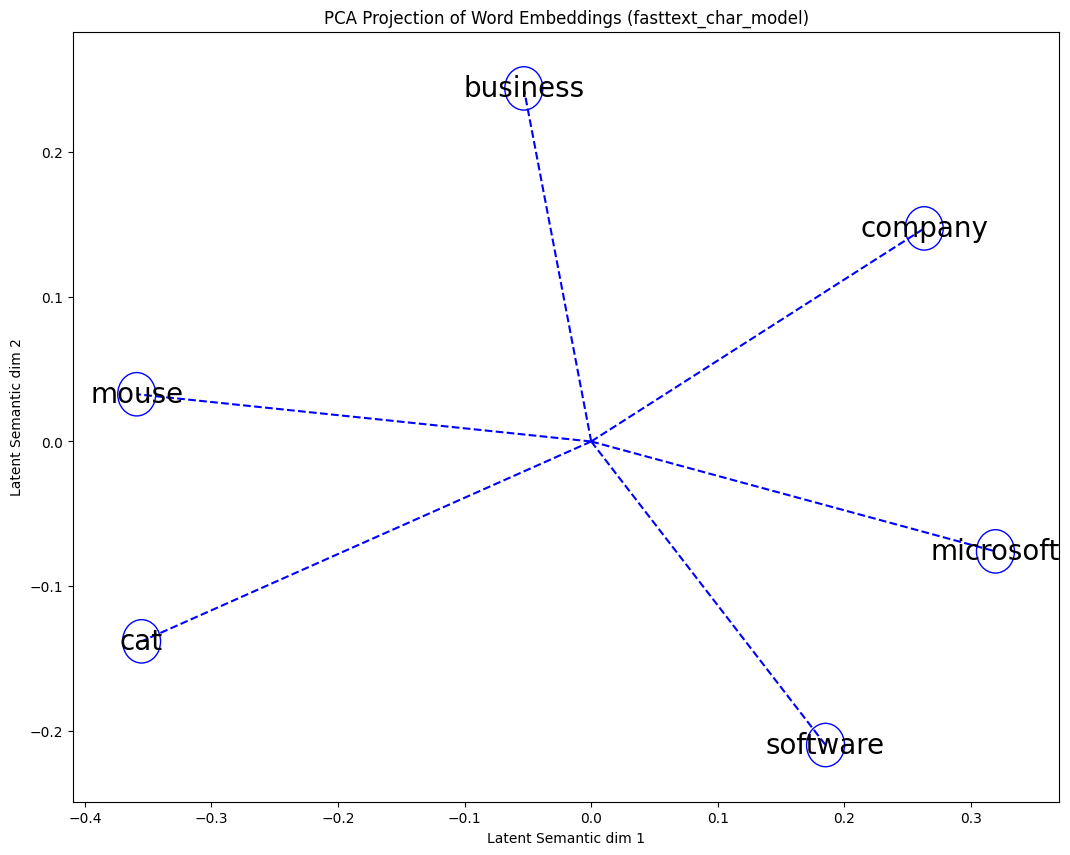

In [ ]:
# Function to save plot
def save_plot(fig, filename, folder="plots"):
    """
    Saves the current plot to the specified folder with the given filename.

    Args:
        fig: Matplotlib figure object.
        filename (str): Name of the file to save (e.g., 'plot.png').
        folder (str): Folder where the plot should be saved.
    """
    # Ensure the folder exists
    os.makedirs(folder, exist_ok=True)

    # Save the figure
    fig.savefig(os.path.join(folder, filename), bbox_inches="tight")
    print(f"Plot saved to {os.path.join(folder, filename)}")

def get_vector_transform(word, model, pca, n=2):
    word_vec = model[word]
    word_vec = word_vec.reshape(1, -1)
    transformed_vec = pca.transform(word_vec)[:, :n]  # Select the top n components
    return transformed_vec.flatten()  # Return the flattened vector

# Collect word vectors for the given words
words = ['company', 'business', 'cat', 'software', 'microsoft', 'mouse']
word_vectors = np.array([current_model[word] for word in words if word in current_model])

# Fit PCA
pca_word_vec = PCA(n_components=n)
pca_word_vec.fit(word_vectors)

# Transform word vectors
transformed_word_vectors = [get_vector_transform(i, current_model, pca_word_vec, n=2) for i in words]

# Plot transformed vectors
fig = plt.figure(figsize=(28, 10))  # Create a figure to save later
ax = plt.subplot(1, 2, 1)

for idx, vec in enumerate(transformed_word_vectors):
    # Plot line from origin to transformed vector
    plt.plot([0, vec[0]], [0, vec[1]], 'b--')
    # Add a circle at the transformed vector position
    circle = plt.Circle((vec[0], vec[1]), radius=0.015, color='blue', fill=False)
    ax.add_patch(circle)
    # Annotate the word at the transformed vector position
    label = ax.annotate(words[idx], xy=(vec[0], vec[1]), fontsize=20, ha="center", va="center")

# Add labels
plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')
plt.title(f'PCA Projection of Word Embeddings ({current_model_name})')

# Generate filename with model name
filename = f"word_embeddings_pca_{current_model_name}.png"

# Save the plot to a file
save_plot(fig, filename)

# Show the plot
plt.show()

### 4.3 Comparing with more principal components

**1. Run the cell below to compare different words to the previous list of words. How do they compare? Do these comparisons change significantly when you run with more principal components?**


Similar Words:
Words that are contextually similar, like "software" and "microsoft", have high similarity scores (e.g., 0.7986).
"business" and "company" also have a relatively high similarity score (0.3158), aligning with their shared semantic context.

Dissimilar Words:
Words from different contexts, such as "cat" and "software" or "mouse" and "business", show negative or low similarity scores (e.g., -0.3071 for "cat-software").

Self-Similarity:
As expected, comparisons of the same word yield a similarity of 1.0 (e.g., "software-software").

Unexpected Patterns:
Some unrelated pairs have unexpectedly high similarity scores (e.g., "mouse-business": 0.3093), likely due to information loss when reducing to just 2 principal components.



Cosine similarity

No they almost dont change.


$\dots$

In [24]:
print(f"PCA expects {pca_word_vec.n_features_in_} dimensions and transforms to {pca_word_vec.n_components_} components")

PCA expects 100 dimensions and transforms to 2 components


In [25]:
def get_vector_transform(word, model, pca, n=2):
    word_vec = model[word]
    word_vec = word_vec.reshape(1, -1)
    transformed_vec = pca.transform(word_vec)[:, :n]  # Select the top n components
    return transformed_vec.flatten()  # Return the flattened vector

In [26]:
print("Explained variance ratio:", pca_word_vec.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca_word_vec.explained_variance_ratio_))

Explained variance ratio: [0.7332802  0.23953347]
Cumulative explained variance: [0.7332802  0.97281367]


In [ ]:
to_compare = ['software', 'business', 'world'] # Three words, that should be labeled as three different things
for word in words:
    for comparison in to_compare:
        distance = word_similarity(
                                    vec1=get_vector_transform(word, current_model, pca_word_vec, n=n),
                                    vec2=get_vector_transform(comparison, current_model, pca_word_vec,n=n),
                                    glove=None
                                    )
        print(f"{word}-{comparison}: {distance}")
    print()

company-software: 0.2104349285364151
company-business: 0.2916577458381653
company-world: -0.8140895962715149

business-software: -0.8737291097640991
business-business: 1.0
business-world: 0.3180547058582306

cat-software: -0.34435489773750305
cat-business: -0.1557905077934265
cat-world: 0.8869464993476868

software-software: 0.9999998807907104
software-business: -0.8737291097640991
software-world: -0.7390480041503906

microsoft-software: 0.8170966506004333
microsoft-business: -0.4335038959980011
microsoft-world: -0.9922348856925964

mouse-software: -0.7266018986701965
mouse-business: 0.30065926909446716
mouse-world: 0.9998326301574707



## Exercise 5 Screwing around with fasttext models

*A good thing if we want to use fasttext on a character level, is that it will be able to understand spelling errors. We're going to test this now by replacing a bunch of letters in our test set randomly with other words and once more test the accuracy of the word-wise fasttext vs the character-wise fasttext*

In [28]:
def dyslexibot(test_set: list, p=0.05, extra_scuffed=False):
    """
    tHe AlMiGhTy dyslexibot(tm) replaces letters with probability p
    extra_scuffed does what it says: it makes the replacements even harder to guess
    This function is pretty ineffective, if you want to spruce it up, you are welcome to do so
    """

    if extra_scuffed:
        test_set_letters = np.array(list(set(''.join(test_texts)))) # Can replace with all letters currently in test set
    else:
        test_set_letters = np.array(list(string.ascii_lowercase)) # Can only replace with lowercase letters

    new_test_set = [text.split(' ') for text in test_set.copy()]

    print("Replacing text")
    for i, text in tqdm(enumerate(new_test_set)):
        for r, word in enumerate(text):
            word = list(word)
            for t, letter in enumerate(word):
                rand = random.uniform(0, 1)

                if extra_scuffed and rand < p: # We replace even spaces!
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

                elif letter != ' ' and rand < p:
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

            text[r] = ''.join(word)
        new_test_set[i] = ' '.join(text)
    return np.array(new_test_set)

In [29]:
# Showing that dyslexibot works
text = ["have you heard of the tragedy of darth plagueis the wise"]
print(dyslexibot(text, p=0.10, extra_scuffed=False))

Replacing text


1it [00:00, ?it/s]

['have you heard of ths tragedy of darth plagueis the wise']


### 5.1 Dyslexibot and fasttext

**1. Test both the fasttext_word_model and the fasttext_char_model on text generated by dyslexibot. Change the $p$ value and perhaps the $\text{extra scuffed}$ option. Try to make the fasttext_word_model as bad as possible while the fasttext_char_model still keeps somewhat good performance. Comment on what you did to achieve this.**

As the $p$ value increases, the performance of both models worsens. This is because the $p$ value represents the probability of inserted noise in the text. The character-wise model performs way better here, due to its ability to discern character-wise patterns, while the word-wise is unable to find a decent pattern. The extra scuffed option further decreases performance by replacing characters with any other character in the test set, while disabling it only replaces with lowercase letters, which simulates common misspellings. You can imagine this would only further mess up the word-wise model, but also decrease character-wise performance by a little.

The performance for the character-wise model could still be further improved by training the fasttext model on noisy data generated from the dyslexibot, while the word-wise model still wouldn't gain as much from this, since the words are dyslexified at random.

In conclusion, the character-wise model is highly unaffected by misspellings compared to the word-wise model, but it also took 10 times as long to test!

In [30]:
dyslexitext = dyslexibot(test_texts, p=0.20, extra_scuffed=False)

Replacing text


7600it [00:04, 1798.81it/s]


In [31]:
# Define the probabilities and extra_scuffed options to test
p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
extra_scuffed_options = [False, True]

# Initialize lists to store results
results = []

word_time = []
char_time = []

for extra_scuffed in extra_scuffed_options:
    for p in p_values:
        # Generate noisy test data
        dyslexitext = dyslexibot(test_texts, p=p, extra_scuffed=extra_scuffed)
        
        # Test the word-level fastText model
        s1 = time.time()
        word_accs, word_total_acc = test_fasttext_model(fasttext_word_model, dyslexitext, test_labels, ag_news_labels)
        e1 = time.time()

        # Test the character-level fastText model
        s2 = time.time()
        char_accs, char_total_acc = test_fasttext_model(fasttext_char_model, dyslexitext, test_labels, ag_news_labels)
        e2 = time.time()

        word_time.append(e1 - s1)
        char_time.append(e2 - s2)

        # Save results for dataframe
        results.append({
            'Extra Scuffed': extra_scuffed,
            'p Value': p,
            'Word Model Accuracy': word_total_acc,
            'Char Model Accuracy': char_total_acc
        })

# Print time difference
print(f"Word model testing time: {np.sum(word_time)}")
print(f"Char model testing time: {np.sum(char_time)}")

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

Replacing text


7600it [00:02, 3267.65it/s]


Replacing text


7600it [00:04, 1774.96it/s]


KeyboardInterrupt: 

We will plot the accuracy vs probability of character replacement, for both scuffed and not scuffed:

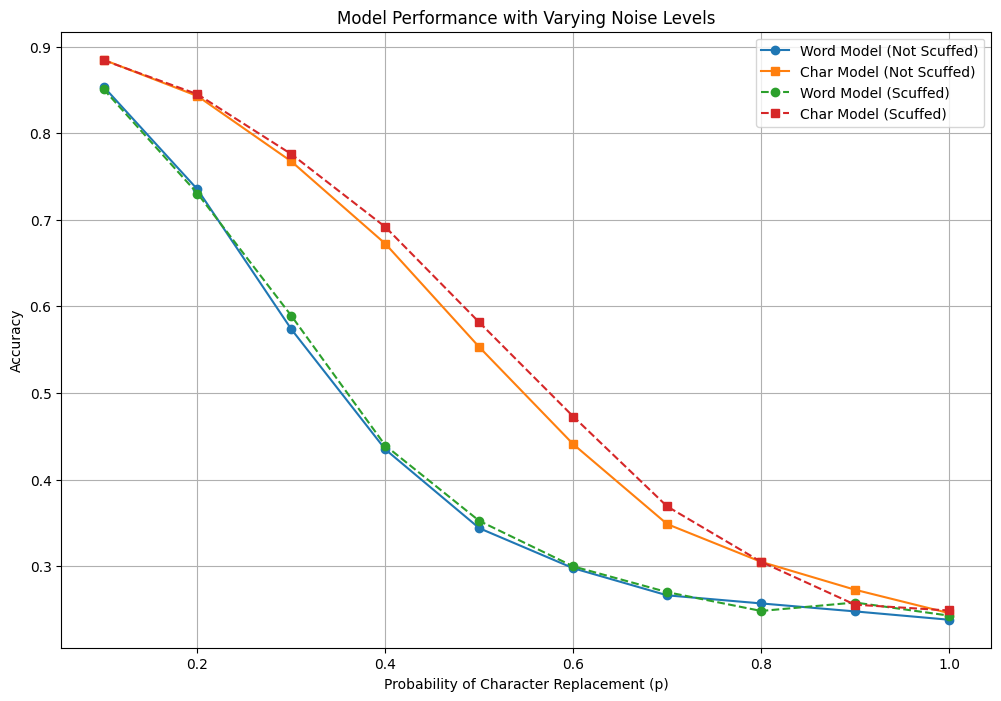

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot for extra_scuffed = False
df_not_scuffed = df_results[df_results['Extra Scuffed'] == False]
plt.plot(df_not_scuffed['p Value'], df_not_scuffed['Word Model Accuracy'],
         marker='o', label='Word Model (Not Scuffed)')
plt.plot(df_not_scuffed['p Value'], df_not_scuffed['Char Model Accuracy'],
         marker='s', label='Char Model (Not Scuffed)')

# Plot for extra_scuffed = True
df_scuffed = df_results[df_results['Extra Scuffed'] == True]
plt.plot(df_scuffed['p Value'], df_scuffed['Word Model Accuracy'],
         marker='o', linestyle='--', label='Word Model (Scuffed)')
plt.plot(df_scuffed['p Value'], df_scuffed['Char Model Accuracy'],
         marker='s', linestyle='--', label='Char Model (Scuffed)')

plt.xlabel('Probability of Character Replacement (p)')
plt.ylabel('Accuracy')
plt.title('Model Performance with Varying Noise Levels')
plt.legend()
plt.grid(True)
plt.show()


### 5.2 Custom text classification

**1. Finally, to show the robustness of fasttext (and for fun), you are to make your own text and try to let fasttext classify this as one of the four models. Rememeber that the original dataset used texts of around 240 words, so you can either experiment with texts shorter or longer than this and see whether the accuracy is significantly different.**

**As an extra challenge, you can try to create a text which is as close to the model's decision boundary as possible, IE. one that is as close as possible to being classified as either two or more of the classes**

We generate 20 different texts with varying topics using ChatGPT's o1-preview model, the first 5 is below 240 words, the next 5 is exactly 240 words (cut off, if there was generated more than 240), the next 5 having above 240 words, and for the extra challenge, the last 5 having exactly 240 words but each with two mixed topics. For the prediction of mixed topics, we just check if it has either one correct. Of course, it is expected that this accuracy is equivalent to that of exactly 240 words, since we expect either one to be correct at the same rate as "exactly 240 words".

We used the following prompts:

"Generate 15 different texts with one of the four possible categories: World, Sports, Business, Sci/Tec. 5 of the texts should be below 240 words, 5 of the texts should be exactly 240 words and the last 5 should be above."

and

"Now generate 5 more texts with 240 words that each have 2 different topics in one text. E.g. first text has World and Sports, the second text has Sci/Tec and Business, etc."

In [ ]:
texts = [
"In a historic gathering, world leaders assembled today for the annual Climate Summit to address the escalating environmental crisis. Representatives from over 100 countries discussed strategies to reduce greenhouse gas emissions and transition to renewable energy sources. Key topics included implementing carbon pricing, investing in sustainable infrastructure, and supporting developing nations affected by climate change. Several nations pledged to achieve net-zero emissions by 2050, with some aiming for even earlier targets. The summit emphasized the importance of international cooperation and technological innovation in combating climate change. Activists and experts stressed that immediate action is necessary to prevent irreversible damage to the planet. While the commitments were praised, critics argued that the measures are insufficient and lack enforceability. The summit concluded with a call to action, urging all countries to accelerate their efforts in addressing the global environmental challenge.",

"In a stunning upset, the underdog Riverside Tigers clinched the National Basketball Championship last night, defeating the heavily favored Metro City Eagles. The game kept fans on the edge of their seats as the Tigers overcame a significant halftime deficit. Star player Alex Ramirez led the charge with 30 points and 12 rebounds, earning the Most Valuable Player award. Coach Sandra Lee credited the victory to the team's relentless spirit and hard work throughout the season. We believed in ourselves when no one else did, she remarked during the post-game interview. The Tigers' win marks their first national title in school history. The victory parade is scheduled for next week, with the entire community expected to celebrate the team's remarkable achievement. Analysts are already calling this game one of the most memorable championships in recent years.",

"In a move that has shaken the tech industry, GlobalTech Corporation announced its acquisition of startup InnovateX for $2 billion. InnovateX, known for its cutting-edge artificial intelligence solutions, will bolster GlobalTech's portfolio in the rapidly growing AI market. The deal is expected to close by the end of the fiscal quarter, pending regulatory approval. GlobalTech's CEO, Maria Thompson, stated that the acquisition aligns with the company's strategic vision to lead in AI development. Combining our resources with InnovateX's innovative technology will accelerate our ability to deliver transformative products to our customers, she said. Investors reacted positively to the news, with GlobalTech's stock price rising by 5% in after-hours trading. Industry experts believe this acquisition could spark a wave of consolidation in the tech sector as companies vie for dominance in AI.",

"Scientists at the National Research Laboratory have announced a significant breakthrough in quantum computing. The research team successfully demonstrated a stable quantum processor capable of performing complex calculations at unprecedented speeds. This development could revolutionize fields such as cryptography, materials science, and drug discovery. Dr. Elena Martinez, the lead researcher, explained that the new processor overcomes previous limitations related to quantum decoherence. Our approach maintains quantum states longer, allowing for more reliable computation, she said. The findings were published in the Journal of Advanced Computing. Experts are hailing this as a major step forward, though practical applications may still be years away. Further research is needed to scale the technology for commercial use. Nevertheless, the breakthrough represents a promising advancement in the quest for powerful quantum computers.",

"After decades of conflict, the governments of Landia and Riverton have signed a historic peace agreement aimed at ending hostilities and fostering cooperation. The treaty, brokered by international mediators, includes provisions for border demarcation, resource sharing, and the return of displaced persons. World leaders praised the agreement as a significant step toward stability in the region. United Nations Secretary-General António Guterres commended both sides for their willingness to negotiate and compromise. This is a beacon of hope for conflict resolution worldwide, he stated. The agreement faces challenges ahead, including implementation and addressing deep-seated mistrust between the populations. However, optimism remains high as both nations prepare to open embassies and establish diplomatic relations.",

"In an electrifying performance at the International Swimming Championships, 23-year-old phenom Michael Anders shattered the world record in the men's 100-meter freestyle. Clocking in at an astonishing 46.80 seconds, Anders surpassed the previous record of 46.91 seconds set by rival swimmer James Collins two years ago. The stadium erupted as Anders touched the wall, realizing he had made history. It's a dream come true, he exclaimed during the post-race interview. I've been training for this moment my entire life. Anders' victory is the culmination of years of dedication and rigorous training under coach Sarah Thompson. Known for her innovative techniques, Thompson has been instrumental in refining Anders' speed and endurance. Michael's work ethic is unparalleled, she noted. He deserves every bit of this success. The race was highly anticipated, featuring a lineup of the world's top swimmers. Anders took an early lead, maintaining a flawless stroke and incredible pace throughout the race. Collins finished a close second, congratulating Anders on his achievement. Records are meant to be broken, Collins remarked graciously. Analysts predict that Anders' record may stand for years, given the margin by which he surpassed the previous time. The swimming community is abuzz with speculation about his potential at the upcoming Olympic Games. Fans worldwide have taken to social media to celebrate the historic moment. Anders' hometown is planning a parade in his honor, recognizing the local hero's remarkable accomplishment. As the sport of swimming reaches new heights",

"In a significant blow to the traditional retail sector, long-standing department store chain GrandMart has filed for Chapter 11 bankruptcy protection. The company cited declining sales, mounting debt, and the relentless rise of e-commerce as primary factors contributing to its financial woes. Founded over 80 years ago, GrandMart was once a staple in shopping malls across the nation, offering a wide array of products from clothing to home goods. However, shifting consumer preferences toward online shopping have eroded its customer base. The COVID-19 pandemic exacerbated the situation, with prolonged store closures and reduced foot traffic. CEO Linda Roberts announced the decision in a press release. This was an incredibly difficult choice, but necessary to restructure our operations and emerge stronger, she stated. The company plans to close 150 underperforming stores while seeking buyers for remaining assets. Industry experts view GrandMart's bankruptcy as indicative of broader challenges facing brick-and-mortar retailers. The retail landscape is evolving rapidly, commented analyst Mark Stevens. Companies must adapt or risk obsolescence. Employees and suppliers are bracing for the impact. The company employs over 20,000 workers, many of whom face uncertain futures. Unions are advocating for fair severance packages and job placement assistance. Meanwhile, competitors in the e-commerce space continue to thrive. Online giants report record profits, capitalizing on the digital shopping trend. Some suggest that GrandMart's failure to invest adequately in online platforms contributed to its downfall. The bankruptcy proceedings will unfold over the coming months",

"Researchers at the University of GreenTech have unveiled a groundbreaking method to accelerate plastic degradation, potentially revolutionizing waste management and environmental conservation. The team engineered a strain of bacteria capable of breaking down polyethylene terephthalate (PET), a common plastic, within weeks rather than centuries. Led by Dr. Emily Hart, the scientists modified the enzyme PETase, enhancing its ability to digest plastic molecules more efficiently. Our enhanced enzyme can reduce PET plastics to their basic components in a fraction of the time, Dr. Hart explained. This could be a game-changer in addressing plastic pollution. Laboratory tests demonstrated that the engineered bacteria decomposed PET samples by 90% within 60 days. Traditional plastics can persist in the environment for hundreds of years, accumulating in landfills and oceans. Environmentalists are cautiously optimistic. If scalable, this technology could significantly mitigate plastic waste, noted Lisa Perez of the Environmental Protection Agency. However, she emphasized the importance of assessing ecological impacts before widespread application. The team is exploring ways to implement the technology on an industrial scale. Potential applications include treating plastic waste at recycling facilities or contaminated sites. Partnerships with waste management companies are being considered to pilot large-scale operations. Critics urge careful consideration of releasing genetically modified organisms into the environment. We must ensure that such interventions do not create unforeseen ecological problems, warned bioethicist Dr. Alan Monroe. Funding for the research was provided by government grants and private environmental foundations. The findings have been",

"Leaders from ten nations signed a landmark trade agreement today, establishing the Pacific Regional Economic Partnership (PREP), aimed at enhancing economic integration and reducing trade barriers among member countries. The pact is expected to increase trade flows, promote investment, and foster economic growth across the region. The signing ceremony took place in Singapore, with heads of state and trade ministers in attendance. This agreement represents a new era of cooperation and shared prosperity, declared Singapore's Prime Minister Lee Tan. By working together, we can achieve greater economic resilience and opportunity for our peoples. Key provisions of the agreement include the elimination of tariffs on 90% of goods, the harmonization of regulations, and the facilitation of services trade. The deal also encompasses commitments to environmental standards and labor rights. Economists predict that the PREP could boost the collective GDP of member nations by $500 billion over the next decade. The reduction of trade barriers will enhance competitiveness and innovation, commented economist Dr. Maya Patel. Businesses will have access to larger markets, benefiting consumers through lower prices and greater choice. However, the agreement faces criticism from some quarters. Labor unions express concerns about potential job losses in certain sectors due to increased competition. We must ensure that workers are protected and that the benefits of trade are broadly shared, stated union leader Carlos Mendes. Environmental groups caution that increased industrial activity could exacerbate ecological challenges unless properly managed. The agreement includes clauses",

"In a dramatic conclusion to the Open Championship, 19-year-old tennis prodigy Sofia Martinez clinched her first Grand Slam title, defeating world number one Serena Williams in a three-set thriller. The match, lasting over two hours, showcased Martinez's exceptional skill and composure under pressure. Martinez, unseeded in the tournament, defied expectations throughout, eliminating several top-ranked players en route to the final. Her victory over Williams, a seasoned champion with 23 Grand Slam titles, marks one of the most significant upsets in tennis history. I'm overwhelmed with joy, Martinez expressed during the trophy presentation. Facing my idol and winning is beyond anything I imagined. The first set saw Williams dominate with powerful serves and forehands, securing it 6-3. Undeterred, Martinez adjusted her strategy, employing tactical placements and agile movements to take the second set 7-5. The decisive third set was a nail-biter, with Martinez saving match points before sealing the win at 7-6 in a tiebreak. Commentators praised Martinez's performance. Her maturity and tactical intelligence are remarkable for her age, noted former champion Anna Kournikova. Williams graciously acknowledged her opponent. Sofia played exceptionally well. She has a bright future ahead, she said. Martinez's triumph propels her into the global spotlight and significantly boosts her ranking. Sponsors and media outlets are eager to engage with the new star, heralding a potential shift in the sport's landscape. Back home, celebrations erupted as fans gathered to watch the historic match. The government announced plans to",

"Astronomers have announced the discovery of an Earth-sized exoplanet located within the habitable zone of a nearby star system, sparking excitement about the possibility of finding extraterrestrial life. The planet, designated Kepler-1649c, orbits a red dwarf star approximately 300 light-years from Earth. Using data from the Kepler Space Telescope, the research team identified the planet through transit observations, noting that it receives about 75% of the light Earth gets from the Sun. This positions Kepler-1649c within the so-called Goldilocks Zone, where conditions could allow for liquid water on its surface—a key ingredient for life as we know it. Dr. Laura Simmons, the lead astronomer, emphasized the significance of the find. This is one of the most promising exoplanets we've discovered in terms of potential habitability, she said. Its size, estimated to be similar to Earth's, and its temperate orbit make it an exciting target for further study. The discovery has reinvigorated discussions about the prevalence of potentially life-supporting planets in our galaxy. Scientists estimate that there could be billions of such planets orbiting red dwarf stars, which are the most common type of star in the Milky Way. However, challenges remain in determining the planet's actual conditions. Red dwarf stars can emit intense solar flares that might strip away a planet's atmosphere or make the surface inhospitable. Additional observations are needed to assess the planet's atmosphere, composition, and potential magnetic field. Future missions, such as the James Webb Space Telescope and the planned LUVOIR mission, could provide the necessary tools to study exoplanets like Kepler-1649c in greater detail. Spectroscopic analysis may reveal atmospheric components such as oxygen, methane, and other biomarkers indicative of life. The discovery also raises philosophical and ethical questions about humanity's place in the universe and the implications of finding life elsewhere. If life is detected, it could profoundly impact science, religion, and society at large. As technology advances, the search for extraterrestrial life continues to be a unifying endeavor that transcends national boundaries. International collaboration will be essential in exploring these distant worlds and unraveling the mysteries they hold.",

"The global retail industry is undergoing a significant transformation as e-commerce continues to surge, reshaping consumer behavior and market dynamics in the aftermath of the COVID-19 pandemic. The shift toward online shopping, accelerated by lockdowns and social distancing measures, shows no signs of slowing down even as economies reopen. Major e-commerce platforms report record revenues, with some experiencing growth rates exceeding 50% year-over-year. This trend is not limited to established markets; emerging economies are also witnessing rapid adoption of digital commerce, facilitated by increasing internet penetration and mobile device usage. Retail analysts attribute this sustained growth to several factors. Consumers have become accustomed to the convenience of online shopping, which offers a broader selection of products, competitive pricing, and home delivery. Additionally, advancements in logistics and supply chain management have reduced delivery times and improved customer satisfaction. Brick-and-mortar retailers are adapting by integrating online channels into their business models, a strategy known as omnichannel retailing. This approach aims to provide a seamless shopping experience across physical and digital platforms. Companies investing in technology and data analytics are better positioned to understand customer preferences and tailor their offerings accordingly. However, the e-commerce boom presents challenges. Small and medium-sized enterprises (SMEs) may struggle to compete with larger players due to limited resources and technological capabilities. Governments and industry organizations are encouraging SMEs to adopt digital tools, offering training programs and financial incentives. Cybersecurity and data privacy concerns are also at the forefront. The increase in online transactions has led to a rise in cyberattacks and fraud. Businesses must invest in robust security measures to protect consumer data and maintain trust. Moreover, the environmental impact of increased packaging and delivery logistics is under scrutiny. Sustainability initiatives, such as using recyclable materials and optimizing delivery routes to reduce emissions, are becoming essential components of corporate responsibility strategies. Looking ahead, experts predict that technologies like artificial intelligence, augmented reality, and blockchain will further revolutionize e-commerce. Personalized shopping experiences, virtual try-ons, and secure transactions are set to enhance customer engagement. The pandemic has undeniably accelerated the digital transformation of retail. Companies that adapt to these changes stand to thrive in the new landscape, while those resistant may face obsolescence. The ongoing evolution of e-commerce will continue to redefine how consumers interact with brands and make purchasing decisions.",

"In a landmark shift towards sustainable energy, countries around the globe are rapidly adopting renewable energy sources to meet ambitious carbon neutrality goals set for the coming decades. The transition from fossil fuels to renewables like solar, wind, hydroelectric, and geothermal energy is being driven by international agreements, technological advancements, and growing public demand for action on climate change. The Paris Agreement, signed by nearly 200 nations, has been a catalyst for this transformation, with countries committing to limit global warming to well below 2 degrees Celsius above pre-industrial levels. To achieve these targets, governments are implementing policies and incentives that encourage investment in renewable energy infrastructure. China, the world's largest emitter of greenhouse gases, has pledged to reach peak carbon emissions by 2030 and achieve carbon neutrality by 2060. The country is investing heavily in solar and wind power, already leading in installed capacity. Similarly, the European Union has set an ambitious goal to become the first climate-neutral continent by 2050, with member states ramping up renewable energy production and phasing out coal. The United States has re-entered the Paris Agreement and is focusing on modernizing its energy grid, promoting electric vehicles, and supporting clean energy research. The Biden administration's infrastructure plan includes substantial funding for renewable energy projects and aims to decarbonize the power sector by 2035. Developing nations are also participating in the renewable revolution. India plans to install 450 gigawatts of renewable energy capacity by 2030, while African countries are exploring solar and wind projects to provide electricity to remote regions. Technological advancements have made renewables more cost-competitive with traditional energy sources. The cost of solar photovoltaic modules and wind turbines has decreased significantly, making them attractive options for new power generation. Energy storage solutions, like advanced batteries, are addressing the intermittency issues of renewables, enhancing grid stability. Despite progress, challenges remain. Transitioning to renewable energy requires substantial investment, grid modernization, and overcoming regulatory and market barriers. Energy-intensive industries and regions dependent on fossil fuels face economic and social hurdles. Ensuring a just transition for workers and communities affected by the shift is a critical concern. Climate activists stress that time is of the essence. While the acceleration of renewable energy adoption is promising, experts warn that current efforts may not be sufficient to prevent the most severe impacts of climate change. Calls for increased ambition and faster action are growing louder. The global commitment to renewable energy marks a significant step towards a sustainable future. As nations collaborate and innovate, the hope is that collective efforts will mitigate climate risks, promote economic growth, and improve the quality of life worldwide.",

"The rapid advancement of artificial intelligence (AI) and autonomous systems is intensifying global debates over ethical considerations, regulation, and the societal impact of these technologies. As AI becomes increasingly integrated into various sectors—ranging from healthcare and finance to transportation and defense—concerns about privacy, bias, accountability, and job displacement are taking center stage. One of the primary ethical dilemmas revolves around decision-making processes in AI systems, particularly those that affect human lives. For instance, autonomous vehicles must be programmed to make split-second decisions in life-or-death scenarios, raising questions about moral responsibility and the programming of ethical frameworks into machines. In the healthcare sector, AI algorithms assist in diagnostics and treatment planning. While these tools offer enhanced efficiency and accuracy, they also pose risks if the underlying data sets are biased or unrepresentative, potentially leading to disparities in care. Data privacy is another significant concern. AI systems often require vast amounts of personal data to function effectively. High-profile data breaches and misuse scandals have eroded public trust, prompting calls for stricter regulations to protect individuals' information. Employment disruption due to automation is also at the forefront of the debate. While AI has the potential to create new job categories, it simultaneously threatens to displace workers in sectors like manufacturing, customer service, and transportation. Policymakers are grappling with how to manage this transition, considering solutions like retraining programs and social safety nets. International organizations and governments are beginning to address these challenges. The European Union has proposed comprehensive AI regulations focusing on transparency, accountability, and human oversight. The guidelines aim to balance innovation with fundamental rights, imposing stricter rules on high-risk applications. Industry leaders are also participating in shaping ethical standards. Tech companies have established internal ethics boards and are collaborating on initiatives like the Partnership on AI, which brings together academia, industry, and civil society to address AI's societal implications. However, critics argue that self-regulation is insufficient and that more robust, enforceable policies are needed. They emphasize the importance of inclusive dialogue involving diverse stakeholders, including marginalized communities often disproportionately affected by technological changes. Educational institutions are responding by incorporating ethics into computer science and engineering curricula, preparing future professionals to consider the broader impact of their work. The debate extends to AI in military applications, such as autonomous weapons systems, which some warn could lower the threshold for conflict and raise profound ethical questions about delegating life-and-death decisions to machines. As AI continues to evolve, the urgency to establish ethical guidelines and regulatory frameworks grows. Balancing innovation with societal values is a complex challenge that requires international cooperation, multidisciplinary approaches, and ongoing public engagement. The outcome of these debates will shape the trajectory of AI development and its role in society for years to come.",

"The COVID-19 pandemic has precipitated an unprecedented global education crisis, with school closures and remote learning exposing and amplifying existing inequities in access to quality education. As nations grapple with the aftermath, experts warn of a lost generation unless urgent measures are taken to address learning gaps and invest in resilient education systems. According to UNESCO, over 1.6 billion students were affected by school closures at the height of the pandemic. While some countries managed to pivot to online learning, disparities in technology access left millions without formal education for extended periods. In low-income regions, lack of internet connectivity and devices hindered remote learning initiatives. The long-term consequences are profound. Studies indicate significant declines in literacy and numeracy skills, particularly among marginalized communities. The World Bank estimates that learning poverty—defined as the inability of a 10-year-old to read and understand a simple text—could increase from 53% to 63% in low- and middle-income countries. Girls are disproportionately affected, with heightened risks of dropout due to economic pressures, early marriage, and caregiving responsibilities. The Malala Fund projects that 20 million secondary school-aged girls may never return to classrooms. Teachers face challenges as well, adapting to new technologies without adequate training or support. The strain has led to concerns about teacher burnout and attrition, further destabilizing education systems. Governments and international organizations are mobilizing resources to mitigate the crisis. Initiatives include deploying low-tech solutions like radio and television lessons, distributing printed materials, and implementing community-based education programs. Financial constraints pose significant hurdles. The economic downturn has strained public budgets, leading to cuts in education spending at a time when investment is most needed. The United Nations is advocating for increased funding and debt relief measures to enable countries to prioritize education. Innovations in EdTech offer potential solutions. Partnerships between governments, NGOs, and tech companies are developing platforms tailored to diverse contexts. However, ensuring equitable access remains a challenge. Reopening schools safely is a priority, with protocols for hygiene, social distancing, and mental health support. Vaccine distribution inequities complicate efforts, as unvaccinated populations face higher risks of outbreaks, leading to potential reclosures. The crisis underscores the necessity of reimagining education systems to be more inclusive, flexible, and resilient. Emphasizing foundational skills, socio-emotional learning, and digital literacy is critical. Engaging parents and communities in the educational process enhances support structures for students. Global cooperation is essential. Sharing best practices, resources, and expertise can accelerate recovery and build stronger systems. The Sustainable Development Goal of ensuring inclusive and equitable quality education by 2030 hangs in the balance. Without concerted action, the educational setbacks could have lasting impacts on economic development, social cohesion, and global stability. Investing in education is not only a moral imperative but a strategic necessity for a sustainable future.",

"The International Olympic Committee announced today that the upcoming Olympic Games will be held jointly in a historic collaboration between Greece and Turkey, marking a significant step towards improving relations between the two neighboring countries. The decision comes after years of diplomatic efforts to ease tensions over territorial disputes in the Aegean Sea. Both nations will share hosting duties, with events spread across cities in both countries, including Athens and Istanbul. Athletes from around the world have expressed excitement over the unique opportunity to compete in venues that bridge both European and Asian continents. This is more than just a sporting event; it's a symbol of unity and peace, stated IOC President Thomas Bach. The co-hosting arrangement is expected to boost tourism and economic activity in the region, with projections estimating an influx of over one million visitors. Security measures are being heightened to ensure the safety of participants and spectators, involving coordinated efforts between Greek and Turkish authorities. Human rights organizations are keeping a close watch to ensure that preparations respect local communities and environmental standards. The United Nations has praised the initiative, with Secretary-General António Guterres calling it a monumental step towards regional cooperation and harmony. However, some critics question the feasibility of managing logistics across two countries with complex political histories. There are concerns about potential bureaucratic hurdles and infrastructural challenges. In response, both governments have formed a joint committee to oversee planning and execution, emphasizing transparency",

"Tech conglomerate NeuroTech Industries unveiled today its latest breakthrough in biotechnology: a neural interface device that allows seamless communication between the human brain and computers. Named SynapseLink, the device has the potential to revolutionize industries ranging from medicine to finance by enabling direct thought-to-action capabilities. Investors are buzzing, and the company's stock surged by 20% following the announcement. SynapseLink represents a quantum leap in human-computer interaction, stated CEO Dr. Elena Rodriguez during the product launch. The device operates by decoding neural signals and translating them into digital commands, effectively allowing users to control software and hardware with their minds. Potential applications include assisting individuals with disabilities, enhancing virtual reality experiences, and increasing productivity in professional settings. The business implications are vast. Companies are already exploring how SynapseLink can be integrated into their operations to streamline workflows and reduce reliance on traditional input devices like keyboards and mice. In healthcare, the technology could aid in neurorehabilitation, helping patients recover motor functions after strokes or injuries. The gaming industry is particularly excited, seeing opportunities to create more immersive experiences. However, the development raises ethical and regulatory concerns. Data privacy advocates warn about the potential misuse of sensitive neurological data. We're entering uncharted territory where thoughts could be recorded and possibly exploited, cautioned cybersecurity expert Laura Chen. NeuroTech Industries has pledged to implement robust security measures and comply with all regulatory standards. Government agencies are also taking note. Discussions are underway about establishing",

"Global sports apparel giant AthletiCorp announced a landmark merger with innovative wearable tech company FitPulse in a deal valued at $5 billion. The strategic alliance aims to revolutionize the sports industry by integrating advanced technology into athletic wear, offering real-time performance analytics to both professional athletes and everyday fitness enthusiasts. This merger is a game-changer, proclaimed AthletiCorp CEO Marcus Lee. By combining our expertise in sports apparel with FitPulse's cutting-edge technology, we're poised to redefine how individuals interact with their fitness routines. The new line of smart clothing will feature embedded sensors that monitor biometrics such as heart rate, muscle activity, and hydration levels. Data collected will sync with a mobile app, providing personalized feedback and training recommendations. The business implications are significant. Analysts predict that the market for smart athletic wear could exceed $50 billion within the next five years. Investors reacted positively, with AthletiCorp's stock price increasing by 12% following the announcement. The merger positions the company to compete aggressively against rivals in both the sportswear and tech industries. Professional sports teams are already expressing interest. Contracts are being negotiated to supply entire leagues with the smart apparel, potentially enhancing player performance and reducing injuries through better monitoring. This technology could extend athletes' careers by preventing overexertion and optimizing training, noted sports scientist Dr. Karen Simmons. However, the integration of technology raises privacy concerns. Data security experts warn about the potential risks of sensitive health information being hacked",

"In an unprecedented global initiative, scientists and policymakers from over 100 countries convened at the United Nations headquarters to launch the International Climate Technology Alliance. The alliance aims to combat climate change by fostering innovation in renewable energy, carbon capture, and sustainable agriculture. This is a critical moment for humanity, declared UN Secretary-General António Guterres. Through collaboration and technology, we can address the most pressing environmental challenges of our time. The alliance will function as a platform for sharing knowledge, resources, and technological advancements. Developed nations have pledged $50 billion to fund research and development projects in emerging economies, focusing on scalable solutions that can be implemented worldwide. Key initiatives include advancing solar and wind energy technologies, developing efficient energy storage systems, and exploring geoengineering possibilities. Scientists are particularly excited about the potential for collaborative research. Dr. Aisha Mbaye, a leading climatologist from Senegal, emphasized the importance of diverse perspectives. Climate change is a global issue requiring global input. By uniting, we can accelerate breakthroughs that might have taken decades individually. Technological innovation is at the heart of the alliance's strategy. Plans are underway to launch satellites equipped with advanced sensors to monitor environmental changes in real-time. This data will be accessible to all member countries, aiding in disaster preparedness and policy formulation. However, the initiative is not without challenges. Critics argue that technology alone cannot solve the climate crisis without significant policy changes and reductions in greenhouse gas emissions.",

"The National Basketball Association is set to revolutionize the game by integrating artificial intelligence and virtual reality into its upcoming season. Partnering with tech firm VisionSports, the NBA plans to enhance both player performance and fan engagement through cutting-edge technology. We're entering a new era of sports entertainment, announced NBA Commissioner Adam Silver. This initiative will redefine how fans experience basketball and how players train and compete. Players will have access to AI-driven analytics that provide real-time feedback on their performance during games and practices. Wearable sensors will collect data on metrics such as speed, acceleration, and shot accuracy, allowing coaches to make instantaneous strategic adjustments. It's like having a personal analyst with you at all times, said star player LeBron James. This technology could extend careers and elevate the level of competition. For fans, the introduction of virtual reality promises an immersive experience like never before. VisionSports has developed VR headsets that allow viewers to watch games from the perspective of any player on the court or from exclusive courtside seats, all from the comfort of their homes. Interactive features enable fans to access player stats, switch viewing angles, and even participate in virtual halftime shows. The business implications are significant. The NBA expects to increase its global viewership and tap into new revenue streams through subscriptions to the enhanced VR experience. VisionSports stands to gain a substantial market share in the sports technology sector. Advertisers are also keen"
]

# World, Sports, Business, Sci/Tec
true_labels = ["World", "Sports", "Business", "Sci/Tec", "World", "Sports", "Business", "Sci/Tec", "World", "Sports", "Sci/Tec", "Business", "World", "Sci/Tec", "World", ("World", "Sports"), ("Sci/Tec", "Business"), ("Business", "Sports"), ("World", "Sci/Tec"), ("Sports", "Sci/Tec")]

below = []
exact = []
above = []

mixed = []

for text, label in zip(texts, true_labels):
    assert text != "", "Come on, be creative"

    classif = fasttext_char_model.predict(text)
    print("Classified as:", classif[0][0][9:], "with certainty:", classif[1][0])
    text_len = len(text.split())
    print("Amount of words: ", text_len)
    if text_len < 240:
        if type(label) == tuple:
            mixed.append(classif[0][0][9:] == label[0] or classif[0][0][9:] == label[1])
        else:
            below.append(classif[0][0][9:] == label)
    elif text_len == 240:
        if type(label) == tuple:
            mixed.append(classif[0][0][9:] == label[0] or classif[0][0][9:] == label[1])
        else:
            exact.append(classif[0][0][9:] == label)
    else:
        if type(label) == tuple:
            mixed.append(classif[0][0][9:] == label[0] or classif[0][0][9:] == label[1])
        else:
            above.append(classif[0][0][9:] == label)
    print()

print("Accuracy for texts below 240 words:", sum(below)/len(below))
print("Accuracy for texts with 240 words:", sum(exact)/len(exact))
print("Accuracy for texts above 240 words:", sum(above)/len(above))
print("Accuracy for mixed texts:", sum(mixed)/len(mixed))

Classified as: Sci/Tec with certainty: 0.7256988883018494
Amount of words:  138

Classified as: Sports with certainty: 0.9796250462532043
Amount of words:  136

Classified as: Sci/Tec with certainty: 0.513234555721283
Amount of words:  131

Classified as: Sci/Tec with certainty: 0.9150370359420776
Amount of words:  127

Classified as: World with certainty: 0.7323691248893738
Amount of words:  112

Classified as: Sports with certainty: 0.6876688599586487
Amount of words:  240

Classified as: Business with certainty: 0.6291986107826233
Amount of words:  240

Classified as: Sci/Tec with certainty: 0.9390455484390259
Amount of words:  240

Classified as: Business with certainty: 0.7856040596961975
Amount of words:  240

Classified as: Sports with certainty: 0.8405444622039795
Amount of words:  240

Classified as: Sci/Tec with certainty: 0.9281404614448547
Amount of words:  343

Classified as: Sci/Tec with certainty: 0.718658447265625
Amount of words:  381

Classified as: Sci/Tec with certa

In [ ]:
print("Below 240:", below)
print("Exactly 240:", exact)
print("Above 240:", above)
print("Mixed topics (exactly 240):", mixed)

Below 240: [False, True, False, True, True]
Exactly 240: [True, True, True, False, True]
Above 240: [True, False, False, True, False]
Mixed topics (exactly 240): [True, True, False, True, True]


The accuracy for texts with 240 words definitely has the best accuracy, and while texts below and above vary in their distance from 240, it is clear that their performance is worse, with below having the best of the two. The difference in accuracy between below and above could be explained by above having on average a distance of $173.8$ from $240$, and below having an average distance of $111.2$.

We will test if they are significantly different. We cannot use any test with normality assumption due to our small sample size, and we will therefore use Fisher's Exact Test, which is appropriate for comparing proportions in small samples.

In [ ]:
import itertools
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

# Function to perform Fisher's Exact Test between two groups
def perform_fishers_exact(group1, group2, name1, name2):
    # Contingency table
    table = [
        [sum(group1), len(group1) - sum(group1)],
        [sum(group2), len(group2) - sum(group2)]
    ]
    # Perform Fisher's Exact Test
    odds_ratio, p_value = fisher_exact(table, alternative='two-sided')
    return {
        'groups': (name1, name2),
        'odds_ratio': odds_ratio,
        'p_value': p_value
    }

# Prepare data for pairwise comparisons
groups = {
    'below': below,
    'exact': exact,
    'above': above,
    'mixed': mixed
}

# Perform all pairwise comparisons
results = []
for (name1, group1), (name2, group2) in itertools.combinations(groups.items(), 2):
    result = perform_fishers_exact(group1, group2, name1, name2)
    results.append(result)

# Extract p-values for multiple testing correction
p_values = [res['p_value'] for res in results]

# Apply Bonferroni correction
reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')

# Update results with corrected p-values
for res, p_val, rej in zip(results, corrected_p_values, reject):
    res['corrected_p_value'] = p_val
    res['significant'] = rej

# Print the results
for res in results:
    print(f"Comparison between {res['groups'][0]} and {res['groups'][1]}:")
    print(f"  Odds Ratio: {res['odds_ratio']}")
    print(f"  P-Value: {res['p_value']}")
    print(f"  Corrected P-Value: {res['corrected_p_value']}")
    print(f"  Significant Difference: {'Yes' if res['significant'] else 'No'}\n")


ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
from scipy.stats import fisher_exact

# Example contingency table for two groups
# Group1: successes and failures
# Group2: successes and failures
table = [
    [sum(group1), len(group1) - sum(group1)],
    [sum(group2), len(group2) - sum(group2)]
]

odds_ratio, p_value = fisher_exact(table, alternative='two-sided')
print(f"Fisher's Exact Test p-value: {p_value}")


Fisher's Exact Test p-value: 0.5238095238095238


Our sample size is too small for each test of accuracy, so we cannot deny our null hypothesis of our pairwise accuracies being significantly different.

##  $\star$ $\star$ $\star$ Exercise 6 Extremely optional task

**1. It's quite a waste to have all those juicy principle components of the embedding matrices without using them in a classifier of some sort, right?**

**Create a classifier to classify texts as one of the four labels, based on the projections of their words unto a number of the principle components of the embedding matrices. Compare this classifier to the fasttext classifier and reflect on their performance.**

In [ ]:
raise NotImplementedError("Asking for a whole classifier is a bit much, no?")